In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
from tqdm import tqdm

import os
import glob
import random
from PIL import Image, ImageFilter
import matplotlib.pyplot as plt
import numpy as np

from timm.loss import LabelSmoothingCrossEntropy
import timm

from pathlib import Path

c:\Users\ODOBESKURS\ITMO\1 term\models_compression\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 1. Prepare a dataset

In [2]:
class_names = os.listdir('../data/train/')
class_names.sort()
class_len = len(class_names)

In [3]:
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomApply([transforms.RandomRotation(degrees=15, expand=False, center=None, fill=0, interpolation=2)], p=0.3),
    transforms.RandomApply([transforms.RandomAffine(degrees=0, translate=(0.2, 0.2))], p=0.2),
    transforms.RandomApply([transforms.RandomResizedCrop(224)], p=0.1),
    transforms.RandomApply([transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2)], p=0.2),
    transforms.ToTensor(),
])

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

In [4]:
train_dataset = datasets.ImageFolder(Path('../data/train'), transform=train_transform)
val_dataset = datasets.ImageFolder(Path('../data/val'), transform=transform)
test_dataset = datasets.ImageFolder(Path('../data/test'), transform=transform)

13492


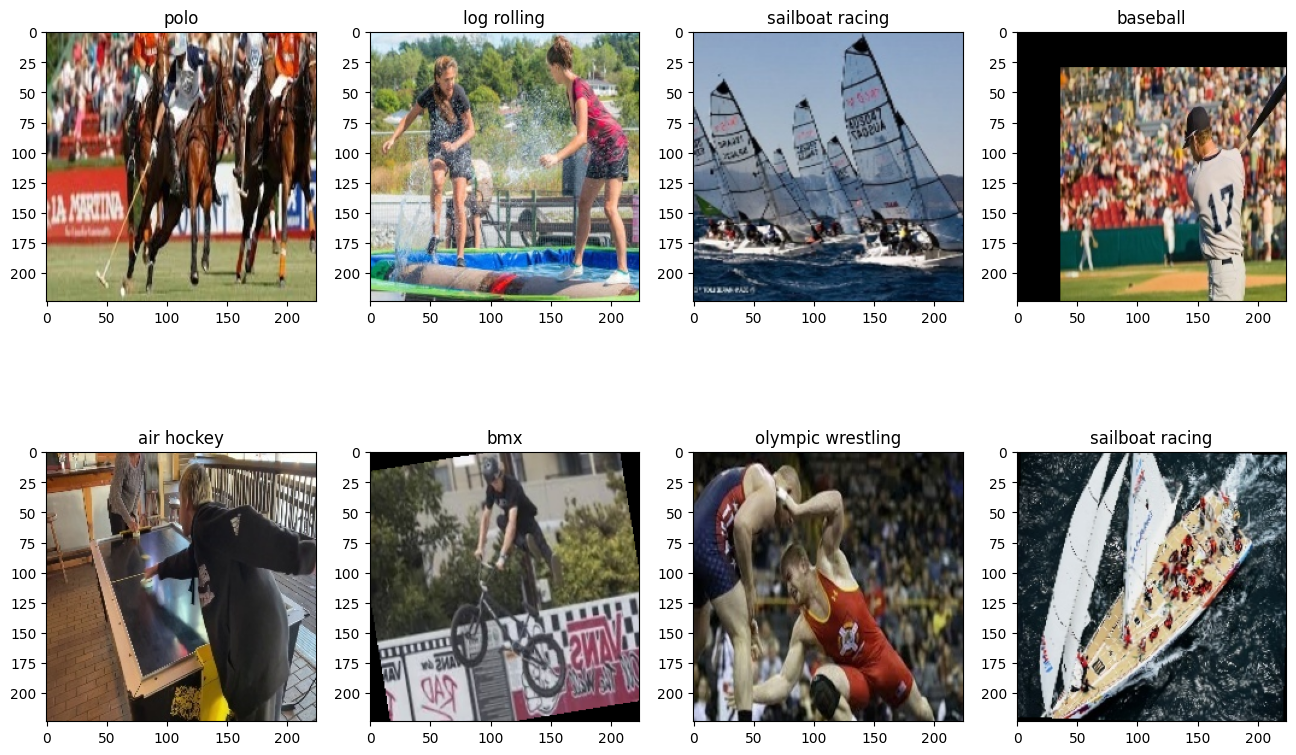

In [5]:

print(len(train_dataset))
_, ax = plt.subplots(2, 4, figsize=(16,10))

for i in range(8):
    data = train_dataset.__getitem__(np.random.choice(range(train_dataset.__len__())))

    image = data[0].cpu().detach().numpy().transpose(1, 2, 0) * 255
    image = image.astype(np.uint32)

    label = data[1]

    ax[i//4][i-(i//4)*4].imshow(image)
    ax[i//4][i-(i//4)*4].set_title(class_names[label])

In [6]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, batch_size=32, shuffle=False)

# 2. Prepare a model

In [7]:
model = models.swin_b(weights='IMAGENET1K_V1')

In [8]:
model

SwinTransformer(
  (features): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
      (1): Permute()
      (2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    )
    (1): Sequential(
      (0): SwinTransformerBlock(
        (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (attn): ShiftedWindowAttention(
          (qkv): Linear(in_features=128, out_features=384, bias=True)
          (proj): Linear(in_features=128, out_features=128, bias=True)
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
        (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (mlp): MLP(
          (0): Linear(in_features=128, out_features=512, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=512, out_features=128, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (1): SwinTransformerBlock

In [9]:
model.head = nn.Sequential(
    nn.Linear(in_features=1024, out_features=512, bias=True),
    nn.ReLU(),
    nn.Dropout(p=0.3, inplace=False),
    nn.Linear(in_features=512, out_features=100, bias=True)
)

# 3. Train a head

In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = LabelSmoothingCrossEntropy()
criterion = criterion.to(device)
optimizer = torch.optim.AdamW(model.head.parameters(), lr=0.001)

best_val_loss = float('inf')
patience = 3  
counter = 0
top1_accuracy = 0.0
top5_accuracy = 0.0

num_epochs = 10

In [11]:
epoch=0
while counter < patience:
    epoch+=1
    epoch_train_loss = 0
    
    for images, labels in tqdm(train_loader, desc='Iterations'):
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        train_loss = criterion(outputs, labels)
        epoch_train_loss += train_loss.item()
        train_loss.backward()
        optimizer.step()
        
    epoch_train_loss /= len(train_loader)
    
    epoch_val_loss = 0
    correct_top1 = 0
    correct_top5 = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            epoch_val_loss += criterion(outputs, labels).item()
            
            # Top-1 и Top-5 accuracy
            _, predicted = outputs.topk(5, dim=1)
            total += labels.size(0)
            correct_top1 += predicted[:, 0].eq(labels).sum().item()
            correct_top5 += predicted.eq(labels.view(-1, 1)).sum().item()

    epoch_val_loss /= len(val_loader)
    top1_accuracy = correct_top1 / total
    top5_accuracy = correct_top5 / total
    
    print(f'Epoch {epoch}. train_loss: {epoch_train_loss:.2f}, val_loss: {epoch_val_loss:.2f}, acc@1: {top1_accuracy}, acc@5: {top5_accuracy}')
    
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        counter = 0
        best_model_weights = model.state_dict()
        torch.save(best_model_weights, f'../models/swin_val_loss={epoch_val_loss:.2f}_acc1={top1_accuracy}_acc5={top5_accuracy}.pth')
    else:
        counter += 1
    
    if counter >= patience:
        print(f"Early stopping after {counter} epochs without improvement.")
        break

    

Iterations: 100%|██████████| 422/422 [02:23<00:00,  2.94it/s]


Epoch 1. train_loss: 2.11, val_loss: 1.39, acc@1: 0.834, acc@5: 0.992


Iterations: 100%|██████████| 422/422 [02:21<00:00,  2.98it/s]


Epoch 2. train_loss: 1.47, val_loss: 1.24, acc@1: 0.904, acc@5: 0.992


Iterations: 100%|██████████| 422/422 [02:21<00:00,  2.98it/s]


Epoch 3. train_loss: 1.39, val_loss: 1.27, acc@1: 0.884, acc@5: 0.996


Iterations: 100%|██████████| 422/422 [02:21<00:00,  2.98it/s]


Epoch 4. train_loss: 1.33, val_loss: 1.22, acc@1: 0.898, acc@5: 0.992


Iterations: 100%|██████████| 422/422 [02:22<00:00,  2.95it/s]


Epoch 5. train_loss: 1.30, val_loss: 1.18, acc@1: 0.914, acc@5: 0.998


Iterations: 100%|██████████| 422/422 [02:23<00:00,  2.94it/s]


Epoch 6. train_loss: 1.29, val_loss: 1.20, acc@1: 0.902, acc@5: 0.994


Iterations: 100%|██████████| 422/422 [02:23<00:00,  2.94it/s]


Epoch 7. train_loss: 1.27, val_loss: 1.19, acc@1: 0.906, acc@5: 0.998


Iterations: 100%|██████████| 422/422 [02:23<00:00,  2.94it/s]


Epoch 8. train_loss: 1.26, val_loss: 1.16, acc@1: 0.93, acc@5: 1.0


Iterations: 100%|██████████| 422/422 [02:23<00:00,  2.94it/s]


Epoch 9. train_loss: 1.25, val_loss: 1.21, acc@1: 0.916, acc@5: 0.996


Iterations: 100%|██████████| 422/422 [02:23<00:00,  2.94it/s]


Epoch 10. train_loss: 1.24, val_loss: 1.21, acc@1: 0.898, acc@5: 0.998


Iterations: 100%|██████████| 422/422 [02:23<00:00,  2.94it/s]


Epoch 11. train_loss: 1.24, val_loss: 1.20, acc@1: 0.906, acc@5: 0.996
Early stopping after 3 epochs without improvement.


# 4. Fine-tune the whole model

In [12]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# model.to(device)

criterion = LabelSmoothingCrossEntropy()
criterion = criterion.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001)

best_val_loss = float('inf')
patience = 3  
counter = 0
top1_accuracy = 0.0
top5_accuracy = 0.0

num_epochs = 10

In [13]:
epoch=0
while counter < patience:
    epoch+=1
    epoch_train_loss = 0
    
    for images, labels in tqdm(train_loader, desc='Iterations'):
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        train_loss = criterion(outputs, labels)
        epoch_train_loss += train_loss.item()
        train_loss.backward()
        optimizer.step()
        
    epoch_train_loss /= len(train_loader)
    
    epoch_val_loss = 0
    correct_top1 = 0
    correct_top5 = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            epoch_val_loss += criterion(outputs, labels).item()
            
            # Top-1 и Top-5 accuracy
            _, predicted = outputs.topk(5, dim=1)
            total += labels.size(0)
            correct_top1 += predicted[:, 0].eq(labels).sum().item()
            correct_top5 += predicted.eq(labels.view(-1, 1)).sum().item()

    epoch_val_loss /= len(val_loader)
    top1_accuracy = correct_top1 / total
    top5_accuracy = correct_top5 / total
    
    print(f'Epoch {epoch}. train_loss: {epoch_train_loss:.2f}, val_loss: {epoch_val_loss:.2f}, acc@1: {top1_accuracy}, acc@5: {top5_accuracy}')
    
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        counter = 0
        best_model_weights = model.state_dict()
        torch.save(best_model_weights, f'../models/swin_val_loss={epoch_val_loss:.2f}_acc1={top1_accuracy}_acc5={top5_accuracy}.pth')
    else:
        counter += 1
    
    if counter >= patience:
        print(f"Early stopping after {counter} epochs without improvement.")
        break

    

Iterations: 100%|██████████| 422/422 [08:02<00:00,  1.14s/it]


Epoch 1. train_loss: 1.18, val_loss: 1.07, acc@1: 0.954, acc@5: 1.0


Iterations: 100%|██████████| 422/422 [07:53<00:00,  1.12s/it]


Epoch 2. train_loss: 1.07, val_loss: 1.02, acc@1: 0.968, acc@5: 1.0


Iterations: 100%|██████████| 422/422 [07:50<00:00,  1.12s/it]


Epoch 3. train_loss: 1.03, val_loss: 0.97, acc@1: 0.972, acc@5: 1.0


Iterations: 100%|██████████| 422/422 [07:50<00:00,  1.12s/it]


Epoch 4. train_loss: 0.99, val_loss: 0.96, acc@1: 0.982, acc@5: 1.0


Iterations: 100%|██████████| 422/422 [08:02<00:00,  1.14s/it]


Epoch 5. train_loss: 0.98, val_loss: 0.95, acc@1: 0.986, acc@5: 1.0


Iterations: 100%|██████████| 422/422 [08:00<00:00,  1.14s/it]


Epoch 6. train_loss: 0.96, val_loss: 0.95, acc@1: 0.988, acc@5: 1.0


Iterations: 100%|██████████| 422/422 [07:50<00:00,  1.12s/it]


Epoch 7. train_loss: 0.95, val_loss: 0.96, acc@1: 0.978, acc@5: 0.998


Iterations: 100%|██████████| 422/422 [07:51<00:00,  1.12s/it]


Epoch 8. train_loss: 0.95, val_loss: 0.94, acc@1: 0.976, acc@5: 0.998


Iterations: 100%|██████████| 422/422 [12:13<00:00,  1.74s/it]


Epoch 9. train_loss: 0.95, val_loss: 0.92, acc@1: 0.984, acc@5: 1.0


Iterations: 100%|██████████| 422/422 [12:01<00:00,  1.71s/it]


Epoch 10. train_loss: 0.93, val_loss: 0.93, acc@1: 0.978, acc@5: 1.0


Iterations: 100%|██████████| 422/422 [09:24<00:00,  1.34s/it]


Epoch 11. train_loss: 0.93, val_loss: 0.91, acc@1: 0.982, acc@5: 1.0


Iterations: 100%|██████████| 422/422 [09:28<00:00,  1.35s/it]


Epoch 12. train_loss: 0.93, val_loss: 0.93, acc@1: 0.98, acc@5: 0.998


Iterations: 100%|██████████| 422/422 [09:16<00:00,  1.32s/it]


Epoch 13. train_loss: 0.92, val_loss: 0.96, acc@1: 0.964, acc@5: 0.998


Iterations: 100%|██████████| 422/422 [09:12<00:00,  1.31s/it]


Epoch 14. train_loss: 0.92, val_loss: 0.92, acc@1: 0.98, acc@5: 1.0
Early stopping after 3 epochs without improvement.
